In [91]:
#essential imports
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize

#scraping imports
import requests
from bs4 import BeautifulSoup

#plotting imports
%matplotlib inline
import matplotlib.pyplot as plt

## 1.  Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
<br>
** Method **
<font color='MidnightBlue'>
Using the postman plugin on google chrome, we found the json representing the list of the universities:

https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508252855868

We want to scrap those data from the site:
* name 
* rank
* country
* region 
* number of faculty members (international and total)
* number of students (international and total)

In the JSON we retrieved, there is already the **name**, **rank**, **country** and **region**. 

In [92]:
#json to dataframe using panda
json_data = json.load(open('TopUniRanking.json'))
df = json_normalize(json_data['data'])
#the university are sorted by ranks, so we just need the 200 first indexes
dfTopUni200 = df.head(200)
#drop useless column information
dfTopUni200 = dfTopUni200.drop(["cc","core_id","logo","guide"],axis=1)
dfTopUni200.head(5)

,country,nid,rank_display,region,score,stars,title,url
0,United States,294850,1,North America,100,6,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,United States,297282,2,North America,98.7,5,Stanford University,/universities/stanford-university
2,United States,294270,3,North America,98.4,5,Harvard University,/universities/harvard-university
3,United States,294562,4,North America,97.7,5,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,United Kingdom,294561,5,Europe,95.6,5,University of Cambridge,/universities/university-cambridge


** Method **
<font color='MidnightBlue'>
<br>

We now have the general data for the 200 first universities. Then we need to scrap data on each unique page of each university to retrieve those 4 informations: 
* **number of total faculty members** 
* **number of international faculty members**
* **number of total students** 
* **number of international students**

The url of each university is contained in our previous dataFrame. And the link to the pages are written this way:
 **https://www.topuniversities.com+url** 
 
Using developper tool in google chrome, we found that the 4 datas we want are located inside unique html objects that have as class: **total faculty**, **inter faculty**, **total student** and **total inter**.
So to find those datas we filter by class name the html page, then we retreive the specific associated information.

<font color='MidnightBlue'>
### **Warning :** the next cell requiers internet to work as intended and it lasts around 2 minutes of computation.

In [ ]:
listUrl = dfTopUni200['url']
#create a temporary dataframe
index = range(200)
columns = ["nbr_faculty_members","nbr_international_faculty_members","nbr_total_students","nbr_international_total_students"]
temp_df = pd.DataFrame(index=index,columns=columns)

#helper function that filter the html file and return the int corresponding to the special string htmlClass
#return NaN if the object doesn't exist
def findNumberOf(soup,htmlClass):
    filteredHtmlElements = soup.find_all('div', class_=htmlClass)
    #case if a field information is not given
    if(len(filteredHtmlElements)==0):
        return np.nan
    #find the integer value inside the html balise
    t= filteredHtmlElements[0].find('div', class_='number').text
    #clear the input then convert it into an integer
    return int(t.replace('\n', '').replace('\r', '').replace(',', '').replace(' ',''))

#retrieve the 4 informations needed from the url, for each university
for i,url in enumerate(listUrl):
    finalUrl = "https://www.topuniversities.com"+url
    r = requests.get(finalUrl)
    soup = BeautifulSoup(r.text, 'html.parser')
    #todo: scrap with beautifulSoup using the url
    #merge data into the temp dataframe
    temp_df.nbr_faculty_members[i] = findNumberOf(soup,'total faculty')
    temp_df.nbr_international_faculty_members[i] = findNumberOf(soup,'inter faculty')
    temp_df.nbr_total_students[i] = findNumberOf(soup,'total student')
    temp_df.nbr_international_total_students[i] = findNumberOf(soup,'total inter')

Now that we have all the informations we want into this DataFrame, we merge it with the initial one.

In [5]:
#merge the old dataframe with the new information
#fullDataFrameTopUni200 contains all the information of the 200 top universities from www.topuniversities.com
fullDataFrameTopUni200 = dfTopUni200.join(temp_df)
fullDataFrameTopUni200.head(5)

,country,nid,rank_display,region,score,stars,title,url,nbr_faculty_members,nbr_international_faculty_members,nbr_total_students,nbr_international_total_students
0,United States,294850,1,North America,100,6,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,2982,1679,11067,3717
1,United States,297282,2,North America,98.7,5,Stanford University,/universities/stanford-university,4285,2042,15878,3611
2,United States,294270,3,North America,98.4,5,Harvard University,/universities/harvard-university,4350,1311,22429,5266
3,United States,294562,4,North America,97.7,5,California Institute of Technology (Caltech),/universities/california-institute-technology-...,953,350,2255,647
4,United Kingdom,294561,5,Europe,95.6,5,University of Cambridge,/universities/university-cambridge,5490,2278,18770,6699


## Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
<br>
** Method **
<font color='MidnightBlue'>
<br>
To answer this question we use the previous DataFrame filtering only interesting parameters in column.
Then we can compute the 2 ratios.

Take note that we drop 2 university that doesn't provide enough information on their personnal page.
Indian Institute of Science (IISc) Bangalore doesn't have the number of international faculty member and New York University (NYU) doesn't have any data at all!

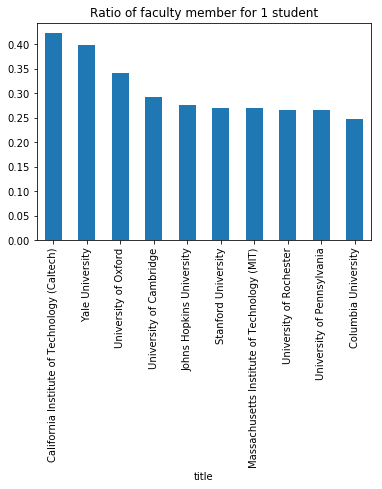

In [6]:
#helper function that compute the ratio of faculty member in function of students
def percentFacAndStud (row):
    return row['nbr_faculty_members']/row['nbr_total_students']
#helper function that compute the ratio of international students in function of total students
def percentInterAndStud (row):
    return row['nbr_international_total_students']/row['nbr_total_students']


#hard copy old DF and drop university that doesn't have the infromation required
filteredDataFrame1 = fullDataFrameTopUni200.copy()[['title','nbr_faculty_members','nbr_international_faculty_members','nbr_total_students','nbr_international_total_students']].dropna()

#create new row with the function percentFacAndStud to compute the ratio faculty member per student
filteredDataFrame1['ratio_faculty_per_student'] = filteredDataFrame1.apply (lambda row: percentFacAndStud (row),axis=1)
#create new row with the function percentInterAndStud to compute the ratio international students in function of total students
filteredDataFrame1['ratio_international_students'] = filteredDataFrame1.apply (lambda row: percentInterAndStud (row),axis=1)

#filter the result to answer question (a)
resultDataFrame=filteredDataFrame1[['title','ratio_faculty_per_student','nbr_faculty_members','nbr_total_students']]
#return the head of the dataframe, sorted by best ratio faculty per student
topRatioFacPerStudent = resultDataFrame.sort_values(by='ratio_faculty_per_student',ascending=False).head(10)

#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent.set_index('title')['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 universities in term of **ratio between faculty members and students** are : 
* California Institute of Technology (Caltech)
* Yale University
* University of Oxford



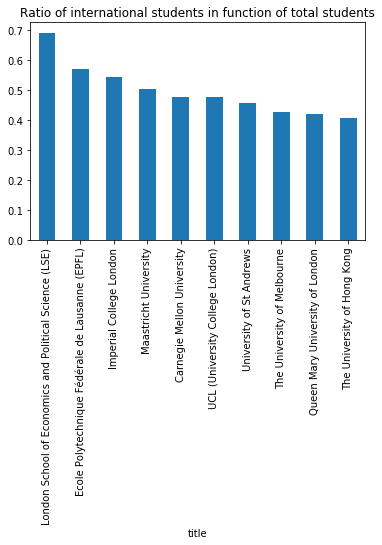

In [7]:
#filter the result to answer question (b)
resultDataFrame=filteredDataFrame1[['title','ratio_international_students','nbr_international_total_students','nbr_total_students']]
#return the head of the dataframe, sorted by best ratio faculty per student
topRatioInterStudents = resultDataFrame.sort_values(by='ratio_international_students',ascending=False).head(10)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents.set_index('title')['ratio_international_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 universities in term of **ratio of international students** are:
* London School of Economics and Political Science
* **Ecole Polytechnique Fédérale de Lausanne (EPFL)**	
* Imperial College London

## Answer the previous question aggregating the data by (c) country and (d) region.

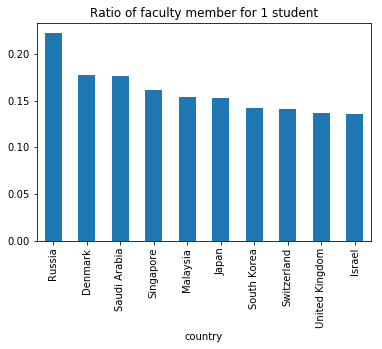

In [8]:
#filter the full dataFrame to only releveant parameters
filteredDataFrame1cd = fullDataFrameTopUni200.copy()[['country','region','nbr_faculty_members','nbr_international_faculty_members','nbr_total_students','nbr_international_total_students']]
#aggregate the countries for question (c)
countryDataFrame = filteredDataFrame1cd.drop('region',axis=1).groupby('country').agg('sum')

#the same helper functions are applied to create the 2 ratio into 2 new columns
countryDataFrame['ratio_faculty_per_student'] = countryDataFrame.apply (lambda row: percentFacAndStud (row),axis=1)
countryDataFrame['ratio_international_students'] = countryDataFrame.apply (lambda row: percentInterAndStud (row),axis=1)

topRatioFacPerStudent = countryDataFrame[['ratio_faculty_per_student','nbr_faculty_members','nbr_total_students']].sort_values(by='ratio_faculty_per_student',ascending=False).head(10)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>
The top 3 countries in term of **ratio between faculty members and students** are:
* Russia
* Denmark
* Saudia Arabia

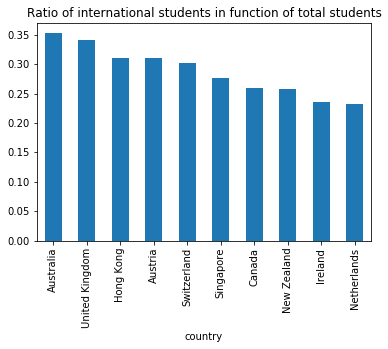

In [9]:
topRatioInterStudents = countryDataFrame[['ratio_international_students','nbr_international_total_students','nbr_total_students']].sort_values(by='ratio_international_students',ascending=False).head(10)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents['ratio_international_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 countries in term of **ratio of international students** are:
* Australia
* United Kingdom	
* Hong Kong

<font color='Black'>
## Answer the previous question for region. (d)
<br> 
** Method **
<font color='MidnightBlue'>
This code is similar to the code of question (c), but instead we aggregate on the label 'region' instead of 'country'.

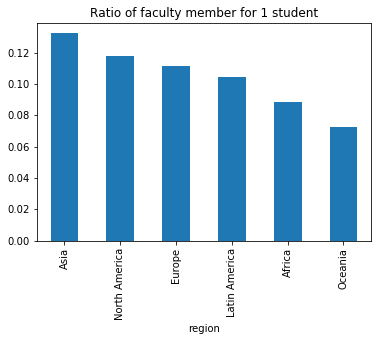

In [10]:
# same code as for the country, but with region
regionDataFrame = filteredDataFrame1cd.drop('country',axis=1).groupby('region').agg('sum')

#the same helper functions are applied to create the 2 ratio into 2 new columns
regionDataFrame['ratio_faculty_per_student'] = regionDataFrame.apply (lambda row: percentFacAndStud (row),axis=1)
regionDataFrame['ratio_international_students'] = regionDataFrame.apply (lambda row: percentInterAndStud (row),axis=1)
topRatioFacPerStudent = regionDataFrame[['ratio_faculty_per_student','nbr_faculty_members','nbr_total_students']].sort_values(by='ratio_faculty_per_student',ascending=False)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 regions in term of **ratio between faculty members and students** are:
* Asia
* North America
* Europe

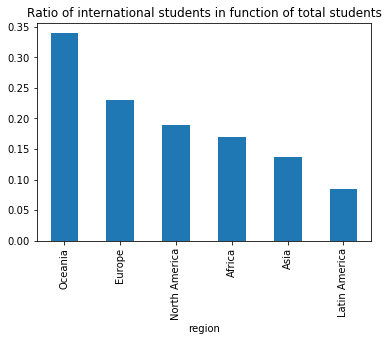

In [11]:
topRatioInterStudents = regionDataFrame[['ratio_international_students','nbr_international_total_students','nbr_total_students']].sort_values(by='ratio_international_students',ascending=False)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents['ratio_international_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>

The top 3 regions in term of **ratio of international students** are:
* Oceania
* Europe
* North America

# 2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

Again using the postman plugin on google chrome, we found the json representing the list of the universities:


https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json

In [12]:
#json to dataframe using panda
json_data2 = json.load(open('TimesRanking.json'))
df2 = json_normalize(json_data2['data'])
#print(df2.T.index)
fullDataFrameTimes200 = df2.copy().head(200)
#clean the data converting string into int
fullDataFrameTimes200['stats_number_students'] = [int(x.replace(',','')) for x in fullDataFrameTimes200.stats_number_students]
fullDataFrameTimes200['stats_student_staff_ratio'] = [1/float(x) for x in fullDataFrameTimes200.stats_student_staff_ratio]
#change "38%" string into 0.38 int
def stringPercentToInt(elem):
    return float(elem.replace('%',''))/100
fullDataFrameTimes200['stats_pc_intl_students'] = [stringPercentToInt(x) for x in fullDataFrameTimes200.stats_pc_intl_students]
fullDataFrameTimes200.head(4)

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,20409,0.38,0.089286,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,18389,0.35,0.091743,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,2209,0.27,0.153846,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,15845,0.22,0.133333,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university


** Remark**
<font color='MidnightBlue'>

Note that we changed **stats_student_staff_ratio** that represent the number of students for one faculty member to the reverse:
the number of **faculty member per student**. This way we have similar reference between this data frame and the one from TopUniversities.com.

The 2 ratios needed for the analysis are already there and there is no more releveant information in specific page of each universities.

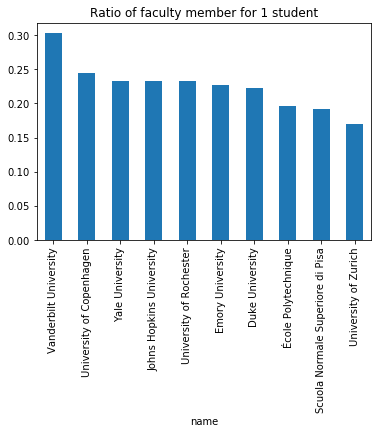

In [13]:
filteredDataFrame2 = fullDataFrameTimes200.copy()[['name','location','rank','stats_pc_intl_students','stats_student_staff_ratio','stats_number_students']]
#sort by ratio and rank too for tie
topRatioFacPerStudent = filteredDataFrame2.sort_values(by=['stats_student_staff_ratio','rank'],ascending=[False,True]).head(10)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent.set_index('name')['stats_student_staff_ratio']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

** Result **
<br>
<font color='MidnightBlue'>
The top 3 universities in term of **ratio between faculty members and students** are:
* Vanderbilt University
* University of Copenhagen
* Yale University

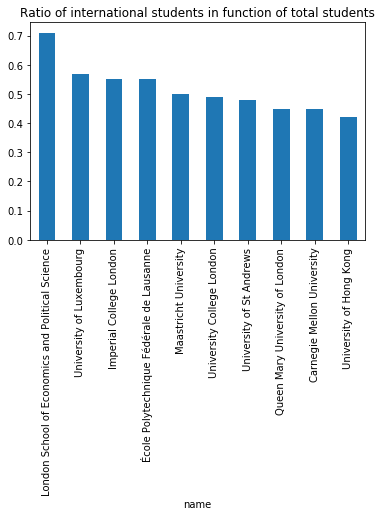

In [14]:
#sort by ratio and rank too for tie
topRatioInterStudents = filteredDataFrame2.sort_values(by=['stats_pc_intl_students','rank'],ascending=[False,True]).head(10)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents.set_index('name')['stats_pc_intl_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<font color='MidnightBlue'>
<br>
The top 3 universities in term of **ratio of international students** are:
* London School of Economics and Political Science
* University of Luxembourg	
* Imperial College London

In contrast with the first dataFrame, we only have the country to agreggate in this case. The problem is that we can't easily aggregate, because we can't just sum the percentage. So we will deduce the number of international student and the number of staff.

In [15]:
#helper function that compute the number of international students
def computeNbrInternationalStudent(row):
    #we floor because the percentage are approximated and floored.
    return int(np.floor(row['stats_pc_intl_students']*row['stats_number_students']))

#helper function that compute the number of staff member
def computeNbrStaffs(row):
    #we floor because the percentage are approximated and floored.
    return int(np.floor(row['stats_student_staff_ratio']*row['stats_number_students']))

#filter the full dataFrame to only releveant parameters 
fullDataFrameTimes200['stats_number_international_students'] = fullDataFrameTimes200.apply (lambda row: computeNbrInternationalStudent (row),axis=1)
fullDataFrameTimes200['stats_number_staffs'] = fullDataFrameTimes200.apply (lambda row: computeNbrStaffs (row),axis=1)

Note that we created 2 columns in the real data frame, maybe thoses data are useful for later. Now we can compute by aggregating like in exercice 1.

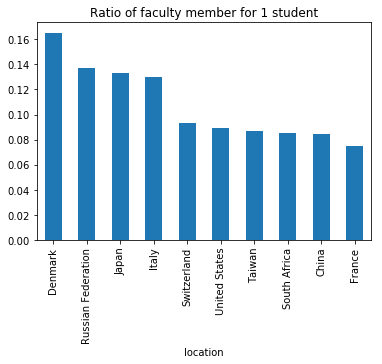

In [16]:
#helper function that compute the ratio of faculty member in function of students
def percentFacAndStud2 (row):
    return row['stats_number_staffs']/row['stats_number_students']
#helper function that compute the ratio of international students in function of total students
def percentInterAndStud2 (row):
    return row['stats_number_international_students']/row['stats_number_students']
#aggregate the countries for question (c)
countryDataFrame2 = fullDataFrameTimes200.copy()[['location','stats_number_international_students','stats_number_staffs','stats_number_students']]
countryDataFrame2 = countryDataFrame2.groupby('location').agg('sum')
#we use the helper functions to create the 2 ratio into 2 new columns
countryDataFrame2['ratio_faculty_per_student'] = countryDataFrame2.apply (lambda row: percentFacAndStud2 (row),axis=1)
countryDataFrame2['ratio_international_students'] = countryDataFrame2.apply (lambda row: percentInterAndStud2 (row),axis=1)
topRatioFacPerStudent = countryDataFrame2[['ratio_faculty_per_student','stats_number_staffs','stats_number_students']].sort_values(by='ratio_faculty_per_student',ascending=False).head(10)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()


** Result **
<font color='MidnightBlue'>
<br>
The top 3 country in term of **ratio between faculty members and students** are:
* Denmark
* Russia
* Japan

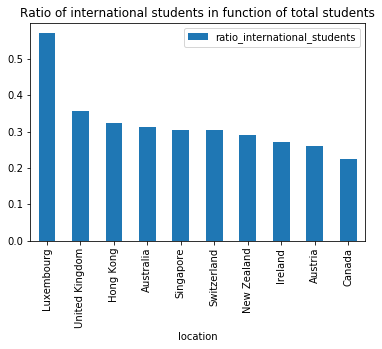

In [17]:
topRatioInterStudents = countryDataFrame2[['ratio_international_students']].sort_values(by='ratio_international_students',ascending=False).head(10)
#plot them in a pie chart:
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

** Result **
<font color='MidnightBlue'>
<br>
The top 3 country in term of **ratio of international students** are:
* Luxembourg
* United Kingdom
* Hong Kong

<font color='Black'>
** Remark **
<br>
<font color='MidnightBlue'>
We notice that some results are different between the data of the 2 sites. There is 2 reasons for that:
* Some universities are not in both data sets, but still have a reallly good ratio. For example the University of Luxembourg (rank 179 and 2nd in ratio of international students) in the seconds site, but is inexistant in TimesUniversities.com.

* There is a difference between the 2 data frames in parameters that should be equivalent.
See next cell.

In [18]:
#data of the site TopUni
data1 = fullDataFrameTopUni200.set_index('title').loc[['Imperial College London','Ecole Polytechnique Fédérale de Lausanne (EPFL)'],['nbr_total_students','nbr_international_total_students']]
print("data of the site TopUni:")
print(data1.to_string())
#data of the site Times
data2 = fullDataFrameTimes200.set_index('name').loc[['Imperial College London','École Polytechnique Fédérale de Lausanne'],['stats_number_students','stats_number_international_students']]
print("-"*100)
print("data of the site Times:")
print(data2.to_string())

data of the site TopUni:
                                                nbr_total_students nbr_international_total_students
title                                                                                              
Imperial College London                                      16090                             8746
Ecole Polytechnique Fédérale de Lausanne (EPFL)              10343                             5896
----------------------------------------------------------------------------------------------------
data of the site Times:
                                          stats_number_students  stats_number_international_students
name                                                                                                
Imperial College London                                   15857                                 8721
École Polytechnique Fédérale de Lausanne                   9928                                 5460


** Remark **
<font color='MidnightBlue'>

Parameters that we think wont vary between the data set (number of students, number of international students,... ) are actually different. It's why the analyse of the 2 ratios between the two sites **return different results** in _Ex.1_ and _Ex.2_. This is maybe due to different standards for counting or to different data update dates.

# 3. merge stuffs
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

** Method**
<font color='MidnightBlue'>To merge properly the two data frames we have to find a standard for the names of the universities. Thus we will remove the sigles (e.g (EPFL) ) and accents. Since the two sites seem to follow the same rule for capital letters, we don't change it. Also we saw that the rankings contain some "=" signs on it that we need to remove for future calculations. Finally we want to put a standard name for the statistics so that we can more easily compare them, average them for mathematical analysis in the next point (correlations).

In [19]:
'''Basic methods to clear the names and ranks'''

# removing accents (most common ones)
def remove_accents (obj):
    return obj.replace('é','e').replace('è','e').replace('ó','o').replace('&','').replace('É','E').replace('ü','u')

# removing equality symbol
def correct_rank (obj):
    return int(obj.replace('=',''))

# removing sigles e.g (EPFL) at the end of Ecole Polytechnique Federale de Lausanne
def remove_sigles (obj):
    # we first look for a sigle in the object (title)
    k = obj.find('(')-1
    if k > 0:
        return obj[0:k] #if there is a sigle we take the object until this symbol
    return obj

In [20]:
cleared_TopUni200 = fullDataFrameTopUni200.copy()

In [21]:
# we want the ratios we computed previously to open more possibilities in the correlation question
cleared_TopUni200['ratio_international_students'] = filteredDataFrame1['ratio_international_students']
cleared_TopUni200['ratio_faculty_per_student'] = filteredDataFrame1['ratio_faculty_per_student']

# now we clear the title and rank in terms of undesired signs and symbols
cleared_TopUni200['title'] = [remove_accents(remove_sigles(s)) for s in cleared_TopUni200['title']]
# here we take the opportunity to rename the rank_display
cleared_TopUni200['rank'] = [correct_rank(k) for k in cleared_TopUni200['rank_display']]
final_TopUni200 = cleared_TopUni200.drop('rank_display',1)

final_TopUni200.head()

,country,nid,region,score,stars,title,url,nbr_faculty_members,nbr_international_faculty_members,nbr_total_students,nbr_international_total_students,ratio_international_students,ratio_faculty_per_student,rank
0,United States,294850,North America,100,6,Massachusetts Institute of Technology,/universities/massachusetts-institute-technolo...,2982,1679,11067,3717,0.335863,0.269450,1
1,United States,297282,North America,98.7,5,Stanford University,/universities/stanford-university,4285,2042,15878,3611,0.227422,0.269870,2
2,United States,294270,North America,98.4,5,Harvard University,/universities/harvard-university,4350,1311,22429,5266,0.234785,0.193945,3
3,United States,294562,North America,97.7,5,California Institute of Technology,/universities/california-institute-technology-...,953,350,2255,647,0.286918,0.422616,4
4,United Kingdom,294561,Europe,95.6,5,University of Cambridge,/universities/university-cambridge,5490,2278,18770,6699,0.356899,0.292488,5


In [22]:
cleared_Times = fullDataFrameTimes200.copy()

# clear names and ranks
cleared_Times['name'] = [remove_accents(remove_sigles(s)) for s in cleared_Times['name']]
cleared_Times['rank'] = [correct_rank(k) for k in cleared_Times['rank']]


# rename interesting statistics to facilitate comparision between both websites
final_Times = cleared_Times.rename(columns = {'stats_number_students':'nbr_total_students',
                                    'stats_number_international_students':'nbr_international_total_students',
                                    'stats_number_staffs':'nbr_faculty_members',
                                    'stats_pc_intl_students':'ratio_international_students',
                                    'stats_student_staff_ratio':'ratio_faculty_per_student',
                                    'location':'country','name':'title'})
final_Times.head()

,aliases,country,member_level,title,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_teaching,scores_teaching_rank,stats_female_male_ratio,nbr_total_students,ratio_international_students,ratio_faculty_per_student,subjects_offered,url,nbr_international_total_students,nbr_faculty_members
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,86.7,5,46 : 54,20409,0.38,0.089286,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford,7755,1822
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,87.8,3,45 : 55,18389,0.35,0.091743,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge,6436,1687
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,3,30,private,99.5,10,...,90.3,1,31 : 69,2209,0.27,0.153846,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...,596,339
3,Stanford University,United States,11,Stanford University,467,3,40,private,99.9,4,...,89.1,2,42 : 58,15845,0.22,0.133333,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university,3485,2112
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,87.3,4,37 : 63,11177,0.34,0.114943,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...,3800,1284


In [87]:
'''*** Merge dataframes ***'''

# now we merge the datas on title by inner join, since what interests us
# for the next questions is also to compare both rankings, so that we want universities that appear in both websites
merged_data = final_Times.merge(final_TopUni200,how = 'inner',suffixes=('_topUni', '_times'), on='title')

# at the end we want to remove country duplicates, 
# supposing that the location is obviously the same even if the formulation may differ

merged_rankings = merged_data.drop('country_times',1).rename(columns={'country_topUni':'country'}).set_index(['country','title'])

merged_rankings.head()

aliases  \
country        title                                                                               
United Kingdom University of Oxford                                         University of Oxford   
               University of Cambridge                                   University of Cambridge   
United States  California Institute of Technology     California Institute of Technology caltech   
               Stanford University                                           Stanford University   
               Massachusetts Institute of Technology       Massachusetts Institute of Technology   

                                                     member_level  nid_topUni  \
country        title                                                            
United Kingdom University of Oxford                             0         468   
               University of Cambridge                          0         470   
United States  California Institute of Technology               0      128779   
               Stanford University                             11         467   
               Massachusetts Institute of Technology            0         471   

                                                      rank_topUni rank_order  \
country        title                                                           
United Kingdom University of Oxford                             1         10   
               University of Cambridge                          2         20   
United States  California Institute of Technology               3         30   
               Stanford University                              3         40   
               Massachusetts Institute of Technology            5         50   

                                                         record_type  \
country        title                                                   
United Kingdom University of Oxford                   master_account   
               University of Cambridge                master_account   
United States  California Institute of Technology            private   
               Stanford University                           private   
               Massachusetts Institute of Technology         private   

                                                     scores_citations  \
country        title                                                    
United Kingdom University of Oxford                              99.1   
               University of Cambridge                           97.5   
United States  California Institute of Technology                99.5   
               Stanford University                               99.9   
               Massachusetts Institute of Technology            100.0   

                                                     scores_citations_rank  \
country        title                                                         
United Kingdom University of Oxford                                     15   
               University of Cambridge                                  29   
United States  California Institute of Technology                       10   
               Stanford University                                       4   
               Massachusetts Institute of Technology                     1   

                                                     scores_industry_income  \
country        title                                                          
United Kingdom University of Oxford                                    63.7   
               University of Cambridge                                 51.5   
United States  California Institute of Technology                      92.6   
               Stanford University                                     60.5   
               Massachusetts Institute of Technology                   88.4   

                                                     scores_industry_income_rank  \
country        title                                     

# 4. Do correlation?

Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

** Method**
<font color='MidnightBlue'> To answer this question, we want to select the statistics that interest us (those that we extracted by means of data scrapping) and  average between the two sources to focus on stats correlations. 

In [88]:
stats_data = merged_rankings.copy()

# here we create a list with the stats that interest us and we need to average between the two websites data
stats = ['nbr_total_students','nbr_international_total_students','nbr_faculty_members','ratio_faculty_per_student','ratio_international_students']

for stat_ in stats:
    # find the stat name in the merged data
    st1 = stat_+'_times'
    st2 = stat_+'_topUni'
    # compute the mean
    stats_data[stat_]= (merged_rankings[st1]+merged_rankings[st2])/2
    # drop useless info
    stats_data= stats_data.drop(st1,1).drop(st2,1)

In [90]:
stats_data[['nbr_international_faculty_members','rank_topUni','rank_times']+stats].head()

nbr_international_faculty_members  \
country        title                                                                     
United Kingdom University of Oxford                                               2964   
               University of Cambridge                                            2278   
United States  California Institute of Technology                                  350   
               Stanford University                                                2042   
               Massachusetts Institute of Technology                              1679   

                                                      rank_topUni  rank_times  \
country        title                                                            
United Kingdom University of Oxford                             1           6   
               University of Cambridge                          2           5   
United States  California Institute of Technology               3           4   
               Stanford University                              3           2   
               Massachusetts Institute of Technology            5           1   

                                                     nbr_total_students  \
country        title                                                      
United Kingdom University of Oxford                             20064.5   
               University of Cambridge                          18579.5   
United States  California Institute of Technology                  2232   
               Stanford University                              15861.5   
               Massachusetts Institute of Technology              11122   

                                                     nbr_international_total_students  \
country        title                                                                    
United Kingdom University of Oxford                                              7554   
               University of Cambridge                                         6567.5   
United States  California Institute of Technology                               621.5   
               Stanford University                                               3548   
               Massachusetts Institute of Technology                           3758.5   

                                                     nbr_faculty_members  \
country        title                                                       
United Kingdom University of Oxford                                 4286   
               University of Cambridge                            3588.5   
United States  California Institute of Technology                    646   
               Stanford University                                3198.5   
               Massachusetts Institute of Technology                2133   

                                                      ratio_faculty_per_student  \
country        title                                                              
United Kingdom University of Oxford                                    0.215789   
               University of Cambridge                                 0.192116   
United States  California Institute of Technology                      0.288231   
               Stanford University                                     0.201602   
               Massachusetts Institute of Technology                   0.192196   

                                                      ratio_international_students  
country        title                                                                
United Kingdom University of Oxford                                       0.376435  
               University of Cambridge                                    0.353450  
United States  California Institute of Technology                         0.278459  
               Stanford University                                        0.223711  
               Massachusetts Institute of Technology                      0.337

# 5. Best university? (not EPFL)

Can you find the best university taking in consideration both rankings? Explain your approach.

In [ ]:
#harward or stuff
pass


